# Title's success 
### Audience success
Influence of writers and directors

In [1]:
#libraries
library(ggplot2)
library(dplyr) 
library(tidyverse)
library(stringr)
library(igraph)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  3.0.4     ✔ purrr   0.3.2
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘igraph’

The following objects are masked from ‘package:purrr’:

    compose, simplify

The following object is masked from ‘package:tidyr’:

    crossing

The following object is masked from ‘packag

## Load Data

In [2]:
title_crew=read.delim('./../dataset/filtered_title_crew.tsv')


In [3]:
title_ratings=read.delim("./../dataset/filtered_title_ratings.tsv",header=TRUE)


## Transform Title Crew in per line instances

In [4]:
head(title_crew)

tconst    directors writers
1 tt0000001 nm0005690 \\N    
2 tt0000002 nm0721526 \\N    
3 tt0000003 nm0721526 \\N    
4 tt0000004 nm0721526 \\N    
5 tt0000005 nm0005690 \\N    
6 tt0000006 nm0005690 \\N

In [5]:
#cleaning - same steos as is https://github.com/fsbarros98/VD_project/blob/main/src/Cleaning_Crew_Ratings.ipynb
tc_clean=title_crew
nrow(tc_clean)
nrow(tc_clean[tc_clean$directors=='\\N',])/nrow(tc_clean) #Percentage of movies without directors
nrow(tc_clean[tc_clean$writers=='\\N',])/nrow(tc_clean) #Percentage of movies without writers
nrow(tc_clean[tc_clean$writers=='\\N' & tc_clean$directors=='\\N',])/nrow(tc_clean)
#7.8% of movies don't have a director nor a writer, so they shall be removed
tc_clean=tc_clean[tc_clean$writers!='\\N' | tc_clean$directors!='\\N',] #Removing the mentioned rows
nrow(tc_clean[tc_clean$writers=='\\N' & tc_clean$directors=='\\N',]) #Everything went OKAY
nrow(tc_clean)

[1] 1443759

[1] 0.1077001

[1] 0.2804824

[1] 0.07833025

[1] 0

[1] 1330669

In [6]:
head(tc_clean)

tconst    directors writers
1 tt0000001 nm0005690 \\N    
2 tt0000002 nm0721526 \\N    
3 tt0000003 nm0721526 \\N    
4 tt0000004 nm0721526 \\N    
5 tt0000005 nm0005690 \\N    
6 tt0000006 nm0005690 \\N

In [7]:
summary(tc_clean)

       tconst           directors            writers        
 tt0000001:      1   \\N      :  42403   \\N      : 291859  
 tt0000002:      1   nm4529114:    685   nm0000636:    501  
 tt0000003:      1   nm0275421:    670   nm0183659:    420  
 tt0000004:      1   nm0183659:    654   nm0279404:    352  
 tt0000005:      1   nm0617588:    530   nm6264147:    312  
 tt0000006:      1   nm0000428:    508   nm2080770:    281  
 (Other)  :1330663   (Other)  :1285219   (Other)  :1036944  

In [8]:
directors = str_split(tc_clean$directors,',')
writers = str_split(tc_clean$writers,',')

In [9]:
max(lengths(directors)) 
mean(lengths(directors))
min(lengths(directors))

[1] 320

[1] 1.105826

[1] 1

In [10]:
max(lengths(writers)) 
mean(lengths(writers))
min(lengths(writers))

[1] 63

[1] 1.395177

[1] 1

In [11]:
tc_with_directors = data.frame(tconst = rep(tc_clean$tconst, sapply(directors, length)), directors = unlist(directors))
tc_with_directors$director = TRUE
tc_with_directors$writer = FALSE
colnames(tc_with_directors) = c("tconst","nconst","director","writer") 

In [12]:
tc_with_writers = data.frame(tconst = rep(tc_clean$tconst, sapply(writers, length)),writers = unlist(writers))
tc_with_writers$director=FALSE
tc_with_writers$writer=TRUE
colnames(tc_with_writers) = c("tconst","nconst","director","writer") 

In [13]:
tail(tc_with_directors)
tail(tc_with_writers)

tconst    nconst     director writer
1471483 tt9916730 nm10538612 TRUE     FALSE 
1471484 tt9916754 nm9272490  TRUE     FALSE 
1471485 tt9916754 nm8349149  TRUE     FALSE 
1471486 tt9916756 nm10538639 TRUE     FALSE 
1471487 tt9916764 nm6685122  TRUE     FALSE 
1471488 tt9916856 nm10538645 TRUE     FALSE

tconst    nconst     director writer
1856514 tt9916756 nm10538639 FALSE    TRUE  
1856515 tt9916764 nm6687687  FALSE    TRUE  
1856516 tt9916764 nm10538642 FALSE    TRUE  
1856517 tt9916764 nm9641593  FALSE    TRUE  
1856518 tt9916764 nm10538643 FALSE    TRUE  
1856519 tt9916856 nm6951431  FALSE    TRUE

In [14]:
tc_usable = rbind(tc_with_directors,tc_with_writers)

In [15]:
tail(tc_usable)

tconst    nconst     director writer
3328002 tt9916756 nm10538639 FALSE    TRUE  
3328003 tt9916764 nm6687687  FALSE    TRUE  
3328004 tt9916764 nm10538642 FALSE    TRUE  
3328005 tt9916764 nm9641593  FALSE    TRUE  
3328006 tt9916764 nm10538643 FALSE    TRUE  
3328007 tt9916856 nm6951431  FALSE    TRUE

In [16]:
nrow(tc_usable)

[1] 3328007

## Merge with title ratings

In [17]:
tc_tr = inner_join(tc_usable,title_ratings)

Joining, by = "tconst"


In [18]:
tail(tc_tr)

tconst    nconst    director writer averageRating numVotes
1159954 tt9916428 \\N       FALSE    TRUE   4.1           11      
1159955 tt9916538 nm4843252 FALSE    TRUE   8.4            5      
1159956 tt9916538 nm4900525 FALSE    TRUE   8.4            5      
1159957 tt9916538 nm2679404 FALSE    TRUE   8.4            5      
1159958 tt9916544 nm3219235 FALSE    TRUE   7.2           24      
1159959 tt9916720 \\N       FALSE    TRUE   6.0           64

In [19]:
#remove rows with no nconst
tc_tr=tc_tr[tc_tr$nconst!='\\N',] #Removing the mentioned rows
tail(tc_tr)

tconst    nconst    director writer averageRating numVotes
1159952 tt9916362 nm1893148 FALSE    TRUE   6.3           104     
1159953 tt9916362 nm3471432 FALSE    TRUE   6.3           104     
1159955 tt9916538 nm4843252 FALSE    TRUE   8.4             5     
1159956 tt9916538 nm4900525 FALSE    TRUE   8.4             5     
1159957 tt9916538 nm2679404 FALSE    TRUE   8.4             5     
1159958 tt9916544 nm3219235 FALSE    TRUE   7.2            24

In [20]:
#only movies with numVotes > 1000
tc_tr = subset(tc_tr,numVotes>1000)
tail(tc_tr)
nrow(tc_tr)

tconst    nconst    director writer averageRating numVotes
1159595 tt9877170 nm1887138 FALSE    TRUE   6.5            7399   
1159776 tt9894470 nm2244274 FALSE    TRUE   6.1            4576   
1159777 tt9894470 nm2100227 FALSE    TRUE   6.1            4576   
1159800 tt9898858 nm3377973 FALSE    TRUE   5.1           10951   
1159832 tt9900782 nm7992231 FALSE    TRUE   8.5            8828   
1159833 tt9900782 nm7807469 FALSE    TRUE   8.5            8828

[1] 116116

## Make graph

In [21]:
different_people = (unique((tc_tr$nconst)))
n_different_people = length(different_people)
n_different_people

[1] 40697

In [ ]:
film_person = tc_tr %>% select(1,2)
head(film_person)
nrow(film_person)

In [ ]:
film_person_type_rating = tc_tr
film_person_type_rating$shape_v = NA
film_person_type_rating$color_v = NA
film_person_type_rating$color_e = NA
#director shape and color 
film_person_type_rating[film_person_type_rating$director==TRUE,]$shape_v = "csquare"
film_person_type_rating[film_person_type_rating$director==TRUE,]$color_v = "black"
#writer shape and color
film_person_type_rating[film_person_type_rating$writer==TRUE,]$shape_v = "circle"
film_person_type_rating[film_person_type_rating$writer==TRUE,]$color_v = "white"
#ratings color
film_person_type_rating[film_person_type_rating$averageRating >= 7.5,]$color_e = "limegreen"
film_person_type_rating[film_person_type_rating$averageRating <= 5,]$color_e = "firebrick"
film_person_type_rating[(film_person_type_rating$averageRating>5 & film_person_type_rating$averageRating<7.5) ,]$color_e = "darkorange"

head(film_person_type_rating)
tail(film_person_type_rating)

In [ ]:
split_films=split(film_person,film_person$tconst)
length(split_films)

In [ ]:

combination_matrix = c()
for (i in 1:length(split_films)){
    if(length(split_films[[i]][[2]]) > 1) {
        temp = combn(as.vector(split_films[[i]][[2]]),2)
        combination_matrix = cbind(combination_matrix,temp)
    }
}

In [ ]:
wd_film_df = data.frame(from=combination_matrix[1,],to=combination_matrix[2,])

In [ ]:
graph_film_wd = graph_from_data_frame(wd_film_df,directed=FALSE)

In [ ]:
E(graph_film_wd)$color = film_person_type_rating$color_e
V(graph_film_wd)$color = film_person_type_rating$color_v
V(graph_film_wd)$shape = film_person_type_rating$shape_v

In [ ]:
plot(graph_film_wd,vertex.size=1,vertex.label=NA,edge.width=1,curved=FALSE,asp=0,margin=0.5)

In [ ]:
plot(simplify(graph_film_wd),vertex.size=1,vertex.label=NA,edge.width=1,curved=FALSE,asp=0,margin=0.5,display.isolates=FALSE)

In [ ]:
plot(graph_film_wd,vertex.size=2,vertex.label=NA,edge.width=1,display.isolates=FALSE,asp=0.5,margin=0.5)

In [ ]:
plot(graph_film_wd,vertex.size=2,vertex.label=NA,edge.width=1,display.isolates=FALSE, curved=FALSE,asp=0.5,margin=0.5)

## Withdraw movies with ratings below 7


In [21]:
b7 = tc_tr
b7 = subset(b7,averageRating>7)

film_person_b7 = b7 %>% select(1,2)
head(film_person_b7)
nrow(film_person_b7)



tconst    nconst   
13  tt0000012 nm0525908
14  tt0000012 nm0525910
16  tt0000014 nm0525910
17  tt0000014 nm0349785
199 tt0000211 nm0617588
266 tt0000359 nm0617588

[1] 35884

In [22]:
film_person_type_rating_b7 = tc_tr
film_person_type_rating_b7 = subset(film_person_type_rating_b7,averageRating>7)

film_person_type_rating_b7$shape_v = NA
film_person_type_rating_b7$color_v = NA
film_person_type_rating_b7$color_e = NA
#director shape and color 
film_person_type_rating_b7[film_person_type_rating_b7$director==TRUE,]$shape_v = "csquare"
film_person_type_rating_b7[film_person_type_rating_b7$director==TRUE,]$color_v = "firebrick1"
#writer shape and color
film_person_type_rating_b7[film_person_type_rating_b7$writer==TRUE,]$shape_v = "circle"
film_person_type_rating_b7[film_person_type_rating_b7$writer==TRUE,]$color_v = "white"
#ratings color
film_person_type_rating_b7[film_person_type_rating_b7$averageRating >= 7,]$color_e = "deepskyblue"
film_person_type_rating_b7[film_person_type_rating_b7$averageRating >= 8,]$color_e = "deeppink1"
film_person_type_rating_b7[film_person_type_rating_b7$averageRating >= 9,]$color_e = "forestgreen"


head(film_person_type_rating_b7)
tail(film_person_type_rating_b7)

tconst    nconst    director writer averageRating numVotes shape_v
13  tt0000012 nm0525908 TRUE     FALSE  7.4           10395    csquare
14  tt0000012 nm0525910 TRUE     FALSE  7.4           10395    csquare
16  tt0000014 nm0525910 TRUE     FALSE  7.1            4649    csquare
17  tt0000014 nm0349785 TRUE     FALSE  7.1            4649    csquare
199 tt0000211 nm0617588 TRUE     FALSE  7.5            3392    csquare
266 tt0000359 nm0617588 TRUE     FALSE  7.1            2491    csquare
    color_v    color_e    
13  firebrick1 deepskyblue
14  firebrick1 deepskyblue
16  firebrick1 deepskyblue
17  firebrick1 deepskyblue
199 firebrick1 deepskyblue
266 firebrick1 deepskyblue

tconst    nconst    director writer averageRating numVotes shape_v
1159258 tt9840958 nm8957087 FALSE    TRUE   9.4           1050     circle 
1159259 tt9840958 nm4672801 FALSE    TRUE   9.4           1050     circle 
1159268 tt9842732 nm5856741 FALSE    TRUE   8.3           2127     circle 
1159587 tt9876408 nm2797005 FALSE    TRUE   7.2           1443     circle 
1159832 tt9900782 nm7992231 FALSE    TRUE   8.5           8828     circle 
1159833 tt9900782 nm7807469 FALSE    TRUE   8.5           8828     circle 
        color_v color_e    
1159258 white   forestgreen
1159259 white   forestgreen
1159268 white   deeppink1  
1159587 white   deepskyblue
1159832 white   deeppink1  
1159833 white   deeppink1

In [23]:
split_films=split(film_person_b7,film_person_b7$tconst)
length(split_films)

[1] 1443759

In [24]:

combination_matrix = c()
for (i in 1:length(split_films)){
    if(length(split_films[[i]][[2]]) > 1) {
        temp = combn(as.vector(split_films[[i]][[2]]),2)
        combination_matrix = cbind(combination_matrix,temp)
    }
}

In [25]:
wd_film_df_b7 = data.frame(from=combination_matrix[1,],to=combination_matrix[2,])

In [26]:
graph_film_wd_b7 = graph_from_data_frame(wd_film_df_b7,directed=FALSE)

In [27]:
E(graph_film_wd_b7)$color = film_person_type_rating_b7$color_e
V(graph_film_wd_b7)$color = film_person_type_rating_b7$color_v
V(graph_film_wd_b7)$shape = film_person_type_rating_b7$shape_v

Warning message in eattrs[[name]][index] <- value:
“number of items to replace is not a multiple of replacement length”Warning message in vattrs[[name]][index] <- value:
“number of items to replace is not a multiple of replacement length”Warning message in vattrs[[name]][index] <- value:
“number of items to replace is not a multiple of replacement length”

In [41]:
options(repr.plot.width=25,repr.plot.height=18,repr.plot.res=200)

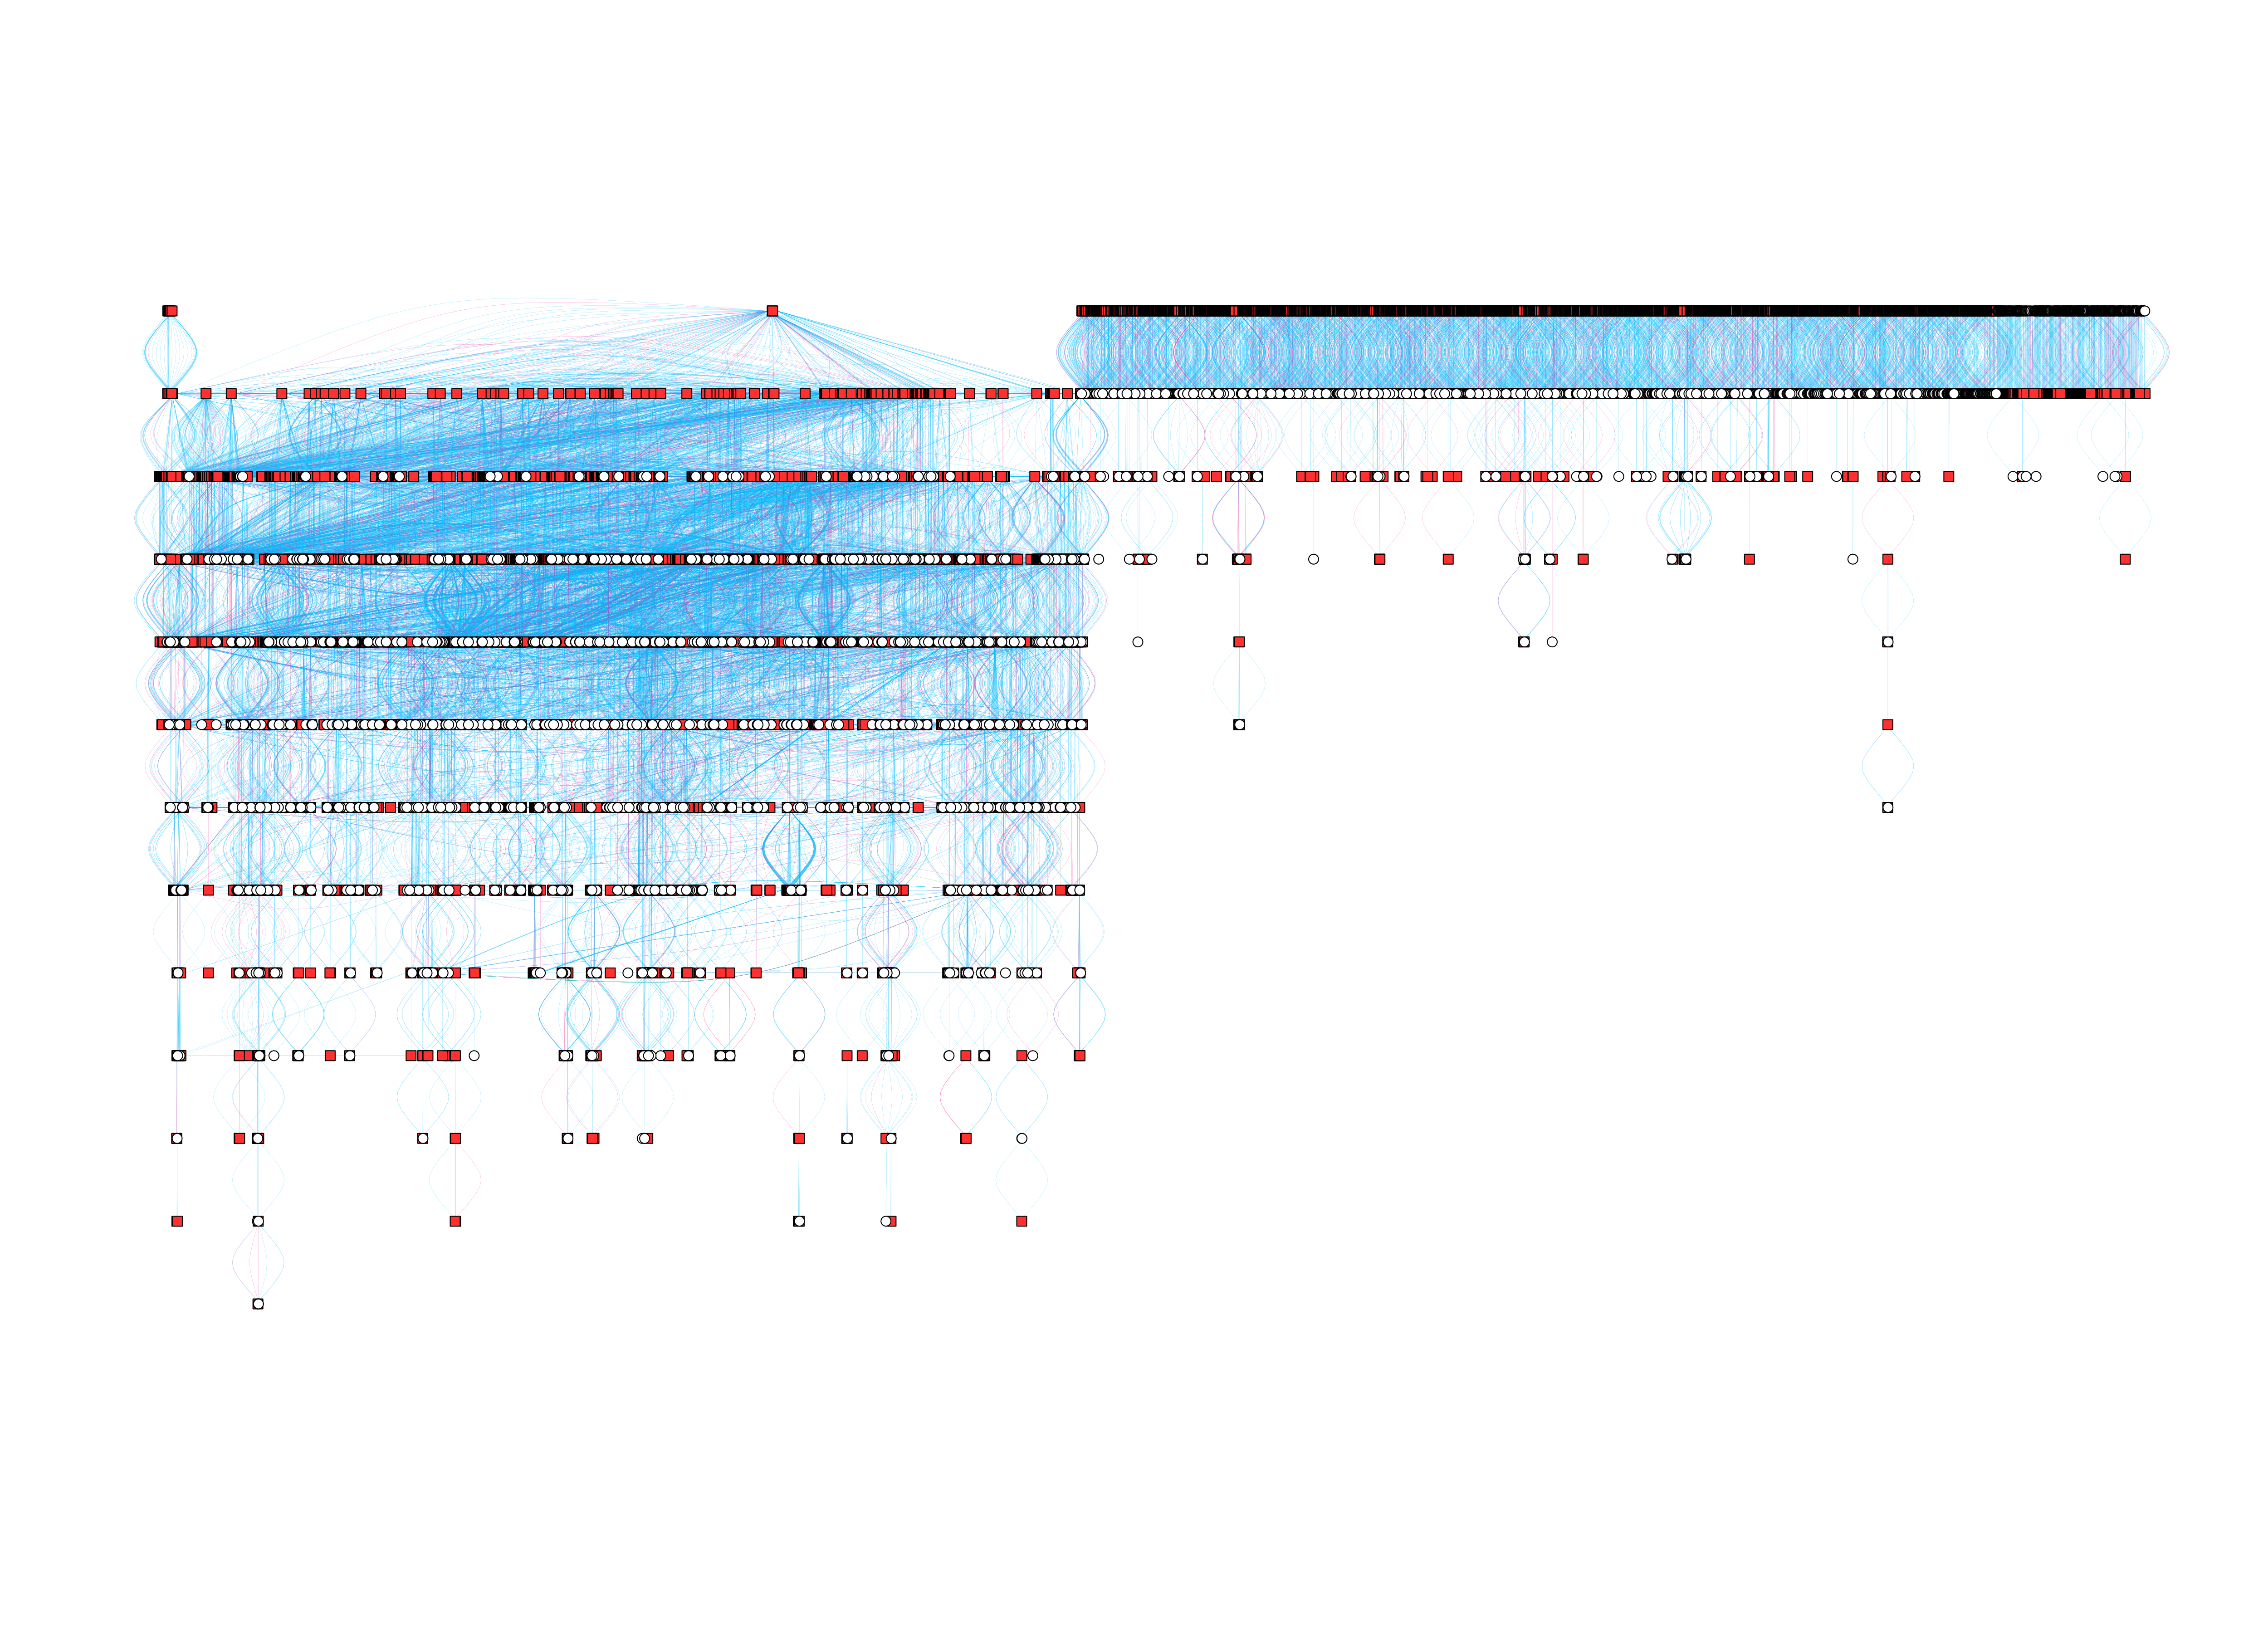

In [46]:
g = simplify(graph_film_wd_b7,remove.multiple = FALSE, remove.loops = TRUE)
coords <- layout_(g, as_tree())
plot(g, layout = coords,display.isolates=FALSE,vertex.size=1,vertex.label=NA,asp=0.5,edge.width=0.1,margin=0)

In [ ]:
plot(graph_film_wd_b7,vertex.size=1,vertex.label=NA,edge.width=1,curved=FALSE,asp=0,margin=0.5)

In [ ]:
plot(simplify(graph_film_wd_b7,remove.multiple = FALSE, remove.loops = TRUE),display.isolates=FALSE,vertex.size=2,vertex.label=NA,edge.width=1,curved=FALSE,asp=0,margin=0.5)

In [ ]:
g = simplify(graph_film_wd_b7,remove.multiple = FALSE, remove.loops = TRUE)
coords <- layout_(g, as_star())
plot(g, layout = coords,display.isolates=FALSE,vertex.size=2,vertex.label=NA,edge.width=0.1,margin=0.5)

In [ ]:
coords <- layout_(g, nicely())
plot(g, layout = coords,display.isolates=FALSE,vertex.size=2,vertex.label=NA,edge.width=1,margin=0.5)

In [ ]:
coords <- layout_(g,on_grid())
plot(g, layout = coords,display.isolates=FALSE,vertex.size=3,vertex.label=NA,edge.width=1,margin=0.5)

In [ ]:
coords <- layout_(g,with_lgl())
plot(g, layout = coords,display.isolates=FALSE,vertex.size=3,vertex.label=NA,edge.width=1)